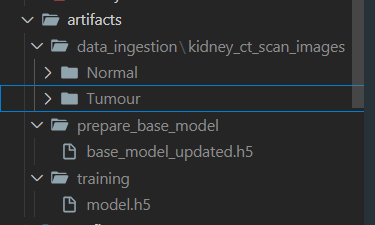

In [1]:
import os

In [2]:
%pwd

'd:\\MLOPs Project\\Kidney_Disease_Classification_Ml_Dvc\\research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'd:\\MLOPs Project\\Kidney_Disease_Classification_Ml_Dvc'

In [5]:
os.environ["MLFLOW_TRACKING_URI"]="https://dagshub.com/SAMANTA1401/Kidney_Disease_Classification_Ml_Dvc.mlflow"
os.environ["MLFLOW_TRACKING_USERNAME"] = "SAMANTA1401"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "922b4b5be2933b85c40e93033b823635135b6510"

In [6]:
# MLFLOW_TRACKING_URI=https://dagshub.com/SAMANTA1401/Kidney_Disease_Classification_Ml_Dvc.mlflow \
# MLFLOW_TRACKING_USERNAME=SAMANTA1401 \
# MLFLOW_TRACKING_PASSWORD=922b4b5be2933b85c40e93033b823635135b6510 \
# python script.py

In [7]:
import tensorflow as tf

In [8]:
model = tf.keras.models.load_model("artifacts/training/model.h5")

In [9]:
##entity
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class EvaluationConfig:
    path_of_model:Path
    training_data:Path
    all_params:dict
    mlflow_uri:str
    params_image_size:list
    params_batch_size:int

In [10]:
from src.cnnClassifier.constants import  *
from src.cnnClassifier.utils.common import read_yaml, create_directories, save_json

In [11]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath=CONFIG_FILE_PATH,
        params_filepath=PARAMS_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        
        create_directories([self.config.artifacts_root])

    def get_evaluation_config(self) -> EvaluationConfig:
        eval_config =EvaluationConfig(
            path_of_model="artifacts/training/model.h5",
            training_data="artifacts/data_ingestion/kidney_ct_scan_images",
            mlflow_uri = "https://dagshub.com/SAMANTA1401/Kidney_Disease_Classification_Ml_Dvc.mlflow",
            all_params = self.params,
            params_image_size = self.params.IMAGE_SIZE,
            params_batch_size = self.params.BATCH_SIZE,
        )

        return  eval_config 


In [12]:
import tensorflow as tf
from pathlib import  Path 
import mlflow 
import mlflow.keras 
from urllib.parse import urlparse

In [13]:
class Evaluation:
    def __init__(self, config:EvaluationConfig):
        self.config = config 

    def _valid_generator(self):
        datagenerator_kwargs = dict(
            rescale = 1./225,
            validation_split = 0.30

        )
        dataflow_kwargs = dict(
            target_size=self.config.params_image_size[:-1],
            batch_size = self.config.params_batch_size,
            interpolation = "bilinear"
        )
        valid_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
            **datagenerator_kwargs
        )
        self.valid_generator = valid_datagenerator.flow_from_directory(
            directory=self.config.training_data,
            subset = "validation",
            shuffle=False,
            **dataflow_kwargs

        )

    @staticmethod
    def load_model(path:Path) -> tf.keras.Model:
        return tf.keras.models.load_model(path)

    def evaluation(self):
        self.model = self.load_model(self.config.path_of_model)
        self._valid_generator()
        self.score = model.evaluate(self.valid_generator)
        self.save_score()

    def save_score(self):
        scores = {"loss":self.score[0], "accuracy":self.score[1]}
        save_json(path=Path("scores.json"), data=scores)

    def log_into_mlflow(self):
        mlflow.set_registry_uri(self.config.mlflow_uri)
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        with mlflow.start_run():
            mlflow.log_params(self.config.all_params)
            mlflow.log_metrics(
                {"loss":self.score[0], "accuracy":self.score[1]}
            )
            # Model registry does not work with file store
            if tracking_url_type_store != "file":
                #Register the model
                # There are other  ways to use the Model Registry, which depends on the use case,
                #please refer to the doc for more imformation
                # https://mlflow.org/docs/latest/model-registry.html
                mlflow.keras.log_model(self.model,"model", registered_model_name="VGG16Model")
            else:
                mlflow.keras.log_model(self.model,"model")



In [14]:
try:
    config=ConfigurationManager()
    eval_config = config.get_evaluation_config()
    evaluation = Evaluation(eval_config)
    evaluation.evaluation()
    evaluation.log_into_mlflow()

except Exception as e:
    raise e

[2024-03-06 20:10:19,443: INFO: common:yaml file: config\config.yaml loaded successfully]
[2024-03-06 20:10:19,446: INFO: common:yaml file: params.yaml loaded successfully]
[2024-03-06 20:10:19,447: INFO: common:created directory at: artifacts]
Found 194 images belonging to 2 classes.
13/13 [==============================] - 36s 3s/step - loss: 15.7871 - accuracy: 0.5258
[2024-03-06 20:10:56,012: INFO: common:json file saved at: scores.json]


2024/03/06 20:12:00 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


[2024-03-06 20:12:02,073: WARNING: save:Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 14). These functions will not be directly callable after loading.]
INFO:tensorflow:Assets written to: C:\Users\lenovo\AppData\Local\Temp\tmp14d0ozh9\model\data\model\assets
[2024-03-06 20:12:03,253: INFO: builder_impl:Assets written to: C:\Users\lenovo\AppData\Local\Temp\tmp14d0ozh9\model\data\model\assets]


d:\MLOPs Project\Kidney_Disease_Classification_Ml_Dvc\kidneyenv\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'VGG16Model'.
2024/03/06 20:13:17 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: VGG16Model, version 1
Created version '1' of model 'VGG16Model'.
